<a href="https://colab.research.google.com/github/issam9/finetuning-bert-models-for-arabic-dialect-detection/blob/main/finetune_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning Arabert, Dziribert and Bert Arabic for Dialect Detection

In [ ]:
!nvidia-smi

Mon Oct 18 16:44:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/aub-mind/arabert.git

Cloning into 'arabert'...
remote: Enumerating objects: 552, done.
remote: Counting objects: 100% (338/338), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 552 (delta 180), reused 239 (delta 89), pack-reused 214
Receiving objects: 100% (552/552), 9.15 MiB | 22.00 MiB/s, done.
Resolving deltas: 100% (303/303), done.


In [ ]:
!pip install -q transformers
!pip install -q datasets
!pip install -q wandb
!pip install -q farasapy
!pip install -q pyarabic
!pip install -q emoji

     |████████████████████████████████| 2.9 MB 4.9 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 596 kB 41.3 MB/s 
     |████████████████████████████████| 3.3 MB 49.3 MB/s 
     |████████████████████████████████| 895 kB 34.9 MB/s 
     |████████████████████████████████| 287 kB 5.4 MB/s 
     |████████████████████████████████| 1.3 MB 39.2 MB/s 
     |████████████████████████████████| 243 kB 49.9 MB/s 
     |████████████████████████████████| 125 kB 50.4 MB/s 
     |████████████████████████████████| 160 kB 43.3 MB/s 
     |████████████████████████████████| 271 kB 48.9 MB/s 
     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 97 kB 6.7 MB/s 
     |████████████████████████████████| 180 kB 44.7 MB/s 
     |████████████████████████████████| 139 kB 42.3 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 126 kB 5.2 MB/s 
     |██████████████████

In [ ]:
import pandas as pd 

from sklearn.model_selection import train_test_split

from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import AutoModel, BertTokenizerFast, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [ ]:
# mount colab
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = Path('/content/drive/MyDrive/ml/projects/msda_dataset/dialect')

In [ ]:
df = pd.read_csv(path/'dialect.csv')
df.head()

,Twits,dialect
0,الدكتورة نجوى قامة في القصف الصاروخي لك ان ترى...,Algerian
1,سكيكدة_المجاهدة❤ صورة تجمع أحد أكبر و أعظم زعم...,Algerian
2,😂😂😂😂😂 شكون يعرفها🤔,Algerian
3,يهود الأندلس للاسف جاو زرعوا الفتنة في وسطنا,Algerian
4,اليهود,Algerian


In [ ]:
df['dialect'].value_counts()

Lebanon     14482
Algerian    13393
Morocco      9965
Tunisian     8044
egypt        7519
Name: dialect, dtype: int64

In [ ]:
dialects = df['dialect'].unique()

lbl2idx = {d: i for i, d in enumerate(dialects)}

df['dialect'] = df['dialect'].map(lbl2idx)

In [ ]:
df['dialect'].unique()

array([0, 1, 2, 3, 4])

In [ ]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Twits'], df['dialect'], random_state=42, 
                                                                    test_size=0.3)

val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, random_state=42, 
                                                                test_size=0.5)

len(train_texts), len(val_texts), len(test_texts)

(37382, 8010, 8011)

### Finetuning arabert

It was recommended to use this preprocessing step when finetuning Arabert models, but i got worse results when i used it.

In [ ]:
from arabert.preprocess import ArabertPreprocessor

bert_model = "aubmindlab/bert-base-arabertv2"
arabert_prep = ArabertPreprocessor(model_name=bert_model)

text = train_texts[0]
prep_text = arabert_prep.preprocess(text)
prep_text

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


100%|██████████| 241M/241M [00:21<00:00, 11.1MiB/s]


[2021-10-18 16:46:36,405 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


'ال+ دكتور +ة نجوى قام +ة في ال+ قصف ال+ صاروخي ل+ +ك ان ترى منشور +ات +ها و+ تدخل +ات +ها'

In [ ]:
BERT_MODEL_NAME = 'aubmindlab/bert-base-arabertv02-twitter'
bert = AutoModel.from_pretrained(BERT_MODEL_NAME)

tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/667 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/516M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dens

Downloading:   0%|          | 0.00/733k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476 [00:00<?, ?B/s]

In [ ]:
# encode text
tokenizer.batch_encode_plus([prep_text], padding=True, return_token_type_ids=False)

{'input_ids': [[2, 298, 17, 15278, 17, 114, 28575, 1178, 17, 114, 305, 298, 17, 9302, 298, 17, 46434, 135, 17, 17, 134, 338, 4989, 35985, 17, 682, 17, 3824, 139, 17, 3403, 17, 682, 17, 3824, 3]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

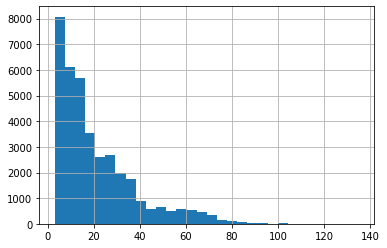

In [ ]:
# get length of all the messages in the train set
seq_len = [len(tokenizer.encode(i)) for i in train_texts]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 40

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=5)

loading configuration file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/1109ac490c1eb90f74960e17c00032f27ea3c4be159567d7ed5d2b5908f9855c.01294502d101541d98086466d32c6b4f04698a90a573cd06480d05bd0c20b2aa
Model config BertConfig {
  "_name_or_path": "bert-base-arabertv02",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "n

If you want to apply Arabert preprocessing, uncomment this code and pass `prep_DStype_texts` to the tokenizer. 

In [ ]:
# prep_train_texts = train_texts.map(arabert_prep.preprocess)
# prep_val_texts = val_texts.map(arabert_prep.preprocess)
# prep_test_texts = test_texts.map(arabert_prep.preprocess)

In [ ]:
train_encodings = tokenizer(train_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
val_encodings = tokenizer(val_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
test_encodings = tokenizer(test_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)

In [ ]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.to_list()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

In [ ]:
train_dataset[0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([    2, 23789,  4683,  7195,   225,  4129,  8531,  5049,   533,  7174,
          1155, 12629, 37260,   394, 13119, 12155,  9446,   558, 33956, 24732,
          8643, 17506,     3,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 'labels': tensor(0),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# function to pass to out trainer in order to compute accuracy, f1 score, precision and recall
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_strategy='epoch',
    evaluation_strategy='epoch'
    )

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 37382
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5845
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.718200,0.532066,0.798377,0.798377,0.798377,0.798377
2,0.409700,0.494719,0.822222,0.822222,0.822222,0.822222
3,0.253100,0.591543,0.824719,0.824719,0.824719,0.824719
4,0.166200,0.664605,0.825468,0.825468,0.825468,0.825468
5,0.118700,0.735836,0.831211,0.831211,0.831211,0.831211


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8010
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8010
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in 

TrainOutput(global_step=5845, training_loss=0.3331769409701802, metrics={'train_runtime': 3330.4434, 'train_samples_per_second': 56.122, 'train_steps_per_second': 1.755, 'total_flos': 3842141563120800.0, 'train_loss': 0.3331769409701802, 'epoch': 5.0})

In [ ]:
trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 8011
  Batch size = 64


PredictionOutput(predictions=array([[-1.9348993 ,  6.5080366 , -2.8530624 ,  0.08406561, -2.1609054 ],
       [-0.09675073, -1.9161195 , -2.8461106 ,  7.140159  , -2.2797828 ],
       [-1.6179178 ,  2.3119361 , -3.9135876 , -1.4768767 ,  6.3328543 ],
       ...,
       [-0.77550006,  0.9115474 , -2.1122346 ,  5.108674  , -3.6134262 ],
       [-0.5345241 ,  0.14545545,  0.13160251,  0.00918229, -0.64934176],
       [ 8.096303  , -1.9068244 , -1.5021762 , -1.9980152 , -2.6741252 ]],
      dtype=float32), label_ids=array([1, 3, 4, ..., 3, 3, 0]), metrics={'test_loss': 0.745388925075531, 'test_accuracy': 0.8319810260891275, 'test_f1': 0.8319810260891275, 'test_precision': 0.8319810260891275, 'test_recall': 0.8319810260891275, 'test_runtime': 38.4405, 'test_samples_per_second': 208.4, 'test_steps_per_second': 3.278})

### Finetuning dziribert

In [ ]:
BERT_MODEL_NAME = 'alger-ia/dziribert'

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=5)

tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

https://huggingface.co/alger-ia/dziribert/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp9m47a0f5


Downloading:   0%|          | 0.00/620 [00:00<?, ?B/s]

storing https://huggingface.co/alger-ia/dziribert/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/b84df24339285511567e2d77586d35cb32e8cbfb526ca5f8494e4b9403a3a705.472e780c5e93b82196f0fa0431ac6f880eb1422e29e1a0ab1edf9ae7662a05a2
creating metadata file for /root/.cache/huggingface/transformers/b84df24339285511567e2d77586d35cb32e8cbfb526ca5f8494e4b9403a3a705.472e780c5e93b82196f0fa0431ac6f880eb1422e29e1a0ab1edf9ae7662a05a2
loading configuration file https://huggingface.co/alger-ia/dziribert/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/b84df24339285511567e2d77586d35cb32e8cbfb526ca5f8494e4b9403a3a705.472e780c5e93b82196f0fa0431ac6f880eb1422e29e1a0ab1edf9ae7662a05a2
Model config BertConfig {
  "_name_or_path": ".",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 7

Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]

storing https://huggingface.co/alger-ia/dziribert/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/c179cf24640b1b0dda4446337f9b96b5c03874251d8f55598a0c05fb34f62a25.9fcdc9919e76b1cfb4bd7813db6afefee31f549a2de09ab0105e38953d8d7781
creating metadata file for /root/.cache/huggingface/transformers/c179cf24640b1b0dda4446337f9b96b5c03874251d8f55598a0c05fb34f62a25.9fcdc9919e76b1cfb4bd7813db6afefee31f549a2de09ab0105e38953d8d7781
loading weights file https://huggingface.co/alger-ia/dziribert/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/c179cf24640b1b0dda4446337f9b96b5c03874251d8f55598a0c05fb34f62a25.9fcdc9919e76b1cfb4bd7813db6afefee31f549a2de09ab0105e38953d8d7781
Some weights of the model checkpoint at alger-ia/dziribert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.Laye

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

storing https://huggingface.co/alger-ia/dziribert/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/790bf116799d324bb9a525c2d5f319f521e05cb00048077ef8b0678305aa3cb1.28ec16a039ec18969e3104c19240ea10320993f34b4b5b32c9445fb0d8353e35
creating metadata file for /root/.cache/huggingface/transformers/790bf116799d324bb9a525c2d5f319f521e05cb00048077ef8b0678305aa3cb1.28ec16a039ec18969e3104c19240ea10320993f34b4b5b32c9445fb0d8353e35
https://huggingface.co/alger-ia/dziribert/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpikmzci8i


Downloading:   0%|          | 0.00/176 [00:00<?, ?B/s]

storing https://huggingface.co/alger-ia/dziribert/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/0af1e7a8d2bf3dc12cb4144a6e619dac782b8db4302e86ccf43c57ec24c26a5d.abb8bf49675bc9db7007e559c3e084b239bbbbc55b1ece04373f6cd14ac2d12a
creating metadata file for /root/.cache/huggingface/transformers/0af1e7a8d2bf3dc12cb4144a6e619dac782b8db4302e86ccf43c57ec24c26a5d.abb8bf49675bc9db7007e559c3e084b239bbbbc55b1ece04373f6cd14ac2d12a
loading file https://huggingface.co/alger-ia/dziribert/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/790bf116799d324bb9a525c2d5f319f521e05cb00048077ef8b0678305aa3cb1.28ec16a039ec18969e3104c19240ea10320993f34b4b5b32c9445fb0d8353e35
loading file https://huggingface.co/alger-ia/dziribert/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/alger-ia/dziribert/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/alger-ia/dziribert/resolve/main/speci

In [ ]:
train_encodings = tokenizer(train_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
val_encodings = tokenizer(val_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
test_encodings = tokenizer(test_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)

In [ ]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.to_list()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    evaluation_strategy='epoch'
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 37382
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5845
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.529300,0.495000,0.825343,0.825343,0.825343,0.825343
2,0.302300,0.478459,0.844320,0.844320,0.844320,0.844320
3,0.136900,0.632986,0.845318,0.845318,0.845318,0.845318
4,0.074400,0.765829,0.848439,0.848439,0.848439,0.848439
5,0.037600,0.847535,0.853059,0.853059,0.853059,0.853059


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8010
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8010
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in 

TrainOutput(global_step=5845, training_loss=0.24106130461288988, metrics={'train_runtime': 3276.8098, 'train_samples_per_second': 57.04, 'train_steps_per_second': 1.784, 'total_flos': 3842141563120800.0, 'train_loss': 0.24106130461288988, 'epoch': 5.0})

In [ ]:
trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 8011
  Batch size = 64


PredictionOutput(predictions=array([[-2.053909  ,  7.934184  , -1.9044272 , -1.7664489 , -2.3044474 ],
       [-1.5769837 , -1.866518  , -2.891408  ,  7.7875896 , -2.4080935 ],
       [-2.633235  ,  0.39042646, -4.2103014 , -0.37818223,  6.5687604 ],
       ...,
       [-1.560371  ,  6.5894794 , -1.1053127 , -0.51805997, -3.4021134 ],
       [-0.18808228, -1.0231497 ,  2.2636597 ,  0.8946254 , -1.8512499 ],
       [ 8.2032585 , -1.9199173 , -1.524513  , -2.211518  , -2.368025  ]],
      dtype=float32), label_ids=array([1, 3, 4, ..., 3, 3, 0]), metrics={'test_loss': 0.8406667709350586, 'test_accuracy': 0.8495818249906378, 'test_f1': 0.8495818249906378, 'test_precision': 0.8495818249906378, 'test_recall': 0.8495818249906378, 'test_runtime': 38.5379, 'test_samples_per_second': 207.873, 'test_steps_per_second': 3.27})

### Finetuning bert-base-arabic

In [ ]:
BERT_MODEL_NAME = 'asafaya/bert-base-arabic'

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=5)

tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

https://huggingface.co/asafaya/bert-base-arabic/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpv3sv36ez


Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

storing https://huggingface.co/asafaya/bert-base-arabic/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/9c5e190e76ab27038700323eb24fad10a0ad90017d4d8a5293e1a2d361823226.9be42b5fcc148338c3790d2adb94f47c610eed8c4dda383d092c3afea817185e
creating metadata file for /root/.cache/huggingface/transformers/9c5e190e76ab27038700323eb24fad10a0ad90017d4d8a5293e1a2d361823226.9be42b5fcc148338c3790d2adb94f47c610eed8c4dda383d092c3afea817185e
loading configuration file https://huggingface.co/asafaya/bert-base-arabic/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/9c5e190e76ab27038700323eb24fad10a0ad90017d4d8a5293e1a2d361823226.9be42b5fcc148338c3790d2adb94f47c610eed8c4dda383d092c3afea817185e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2la

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

storing https://huggingface.co/asafaya/bert-base-arabic/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/9211756159dae4015961bcf4b94e32b2403334fe4795f21e1c42d4ae3980de88.d50e0dd8bfb68450ccfd8270e3d2b4049bfaba3ff8cd85559ae1013f41da29f6
creating metadata file for /root/.cache/huggingface/transformers/9211756159dae4015961bcf4b94e32b2403334fe4795f21e1c42d4ae3980de88.d50e0dd8bfb68450ccfd8270e3d2b4049bfaba3ff8cd85559ae1013f41da29f6
loading weights file https://huggingface.co/asafaya/bert-base-arabic/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9211756159dae4015961bcf4b94e32b2403334fe4795f21e1c42d4ae3980de88.d50e0dd8bfb68450ccfd8270e3d2b4049bfaba3ff8cd85559ae1013f41da29f6
Some weights of the model checkpoint at asafaya/bert-base-arabic were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predicti

Downloading:   0%|          | 0.00/326k [00:00<?, ?B/s]

storing https://huggingface.co/asafaya/bert-base-arabic/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/b826e2a08477c19ebf1b8b7dc4978f3f99a6f9d3107876282ea9691fafe37d98.63883f8c719f41c4f4feb08f611fd3bbe39009b245fef4ec83de8a16821590be
creating metadata file for /root/.cache/huggingface/transformers/b826e2a08477c19ebf1b8b7dc4978f3f99a6f9d3107876282ea9691fafe37d98.63883f8c719f41c4f4feb08f611fd3bbe39009b245fef4ec83de8a16821590be
https://huggingface.co/asafaya/bert-base-arabic/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpks232hia


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/asafaya/bert-base-arabic/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/d9cecabc8bd0dab6bcb5e3905025e7b9b22dc8ee8ca848ef3e44843ee6599aa4.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/d9cecabc8bd0dab6bcb5e3905025e7b9b22dc8ee8ca848ef3e44843ee6599aa4.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
https://huggingface.co/asafaya/bert-base-arabic/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpc7jcjpmm


Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

storing https://huggingface.co/asafaya/bert-base-arabic/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/0a21539d1796cc0b329be5eaa61ce3b2c419c62ae79908dd3e44eefdc9e11552.1788df22ba1a6817edb607a56efa931ee13ebad3b3500e58029a8f4e6d799a29
creating metadata file for /root/.cache/huggingface/transformers/0a21539d1796cc0b329be5eaa61ce3b2c419c62ae79908dd3e44eefdc9e11552.1788df22ba1a6817edb607a56efa931ee13ebad3b3500e58029a8f4e6d799a29
loading file https://huggingface.co/asafaya/bert-base-arabic/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/b826e2a08477c19ebf1b8b7dc4978f3f99a6f9d3107876282ea9691fafe37d98.63883f8c719f41c4f4feb08f611fd3bbe39009b245fef4ec83de8a16821590be
loading file https://huggingface.co/asafaya/bert-base-arabic/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/asafaya/bert-base-arabic/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/asafaya/bert-

In [ ]:
train_encodings = tokenizer(train_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
val_encodings = tokenizer(val_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)
test_encodings = tokenizer(test_texts.to_list(), truncation=True, padding=True, max_length=max_seq_len)

In [ ]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.to_list()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_strategy='epoch',
    evaluation_strategy='epoch'
    )

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=compute_metrics
    )

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 37382
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5845
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.802500,0.582595,0.773159,0.773159,0.773159,0.773159
2,0.437600,0.555227,0.802122,0.802122,0.802122,0.802122
3,0.246600,0.667386,0.808739,0.808739,0.808739,0.808739
4,0.142400,0.801544,0.813733,0.813733,0.813733,0.813733
5,0.085100,0.970458,0.817853,0.817853,0.817853,0.817853


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8010
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8010
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in 

TrainOutput(global_step=5845, training_loss=0.34283581057402496, metrics={'train_runtime': 3217.7812, 'train_samples_per_second': 58.087, 'train_steps_per_second': 1.816, 'total_flos': 3842141563120800.0, 'train_loss': 0.34283581057402496, 'epoch': 5.0})

In [ ]:
trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 8011
  Batch size = 64


PredictionOutput(predictions=array([[-2.5821347 ,  6.849914  , -1.0199473 , -0.34154806, -2.3798485 ],
       [-1.1379589 ,  0.08676509, -3.4301777 ,  5.9239063 , -0.48885247],
       [-2.4305754 ,  0.7522288 , -3.1700583 , -1.3227537 ,  6.22545   ],
       ...,
       [-2.0688086 , -0.89286727, -2.1372752 ,  7.8666964 , -2.212013  ],
       [ 0.345874  ,  0.11339774,  0.3444895 ,  0.25377107, -0.24060829],
       [ 7.9281545 , -1.9170569 , -1.8307225 , -1.7703747 , -1.7162322 ]],
      dtype=float32), label_ids=array([1, 3, 4, ..., 3, 3, 0]), metrics={'test_loss': 0.9470317959785461, 'test_accuracy': 0.8194981899887654, 'test_f1': 0.8194981899887654, 'test_precision': 0.8194981899887654, 'test_recall': 0.8194981899887654, 'test_runtime': 38.4786, 'test_samples_per_second': 208.193, 'test_steps_per_second': 3.275})